# Libraries

In [13]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


# Read Dataset

In [15]:
df = pd.read_csv('../datasets/clean/clean_dataset.csv')
df.head()

,label,review
0,negative,parah stnk kirim transaksi anggap selesai ming...
1,negative,ribet bikin malas bayar pajak
2,negative,aplikasi bodoh verifikasi data valid baru dukc...
3,negative,susah bayar kode bayar salah input sesuai kode...
4,negative,bayar ongkir express kirim jemput bola ongkir ...


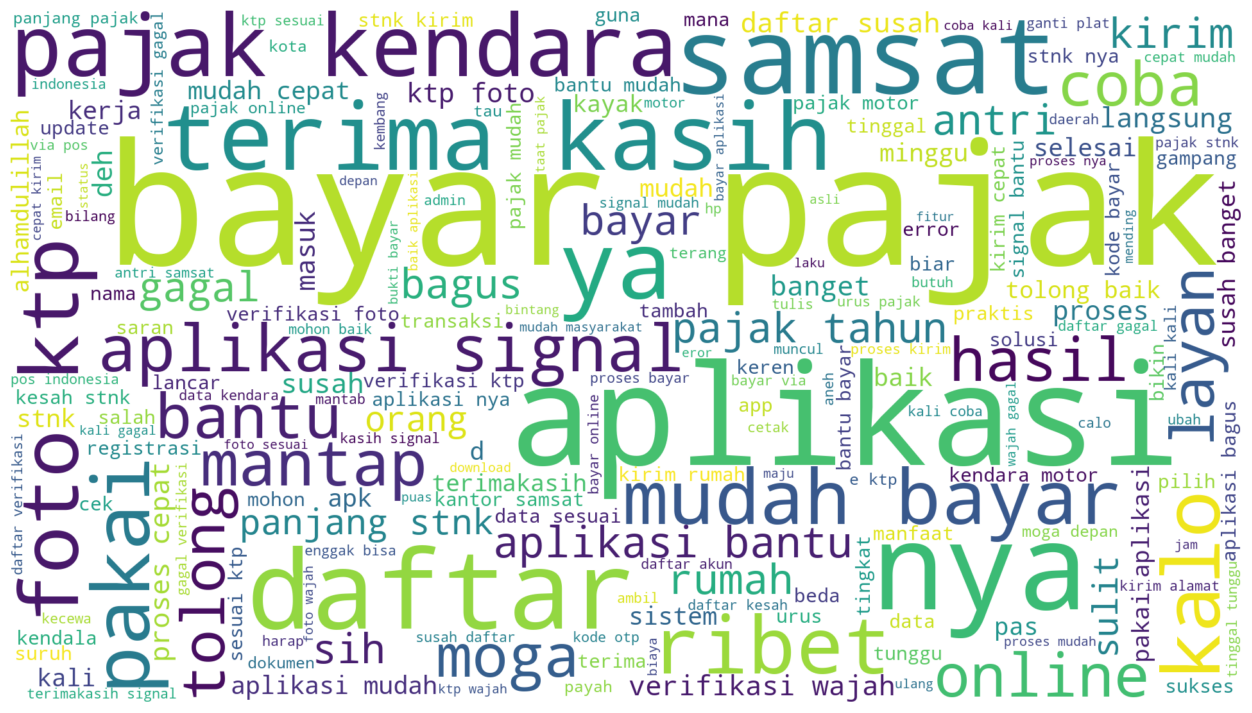

In [16]:
# word cloud
text_data = " ".join(df['review'])

wordcloud = WordCloud(width=1920, height=1080, max_words=200, background_color='white').generate(text_data)

plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

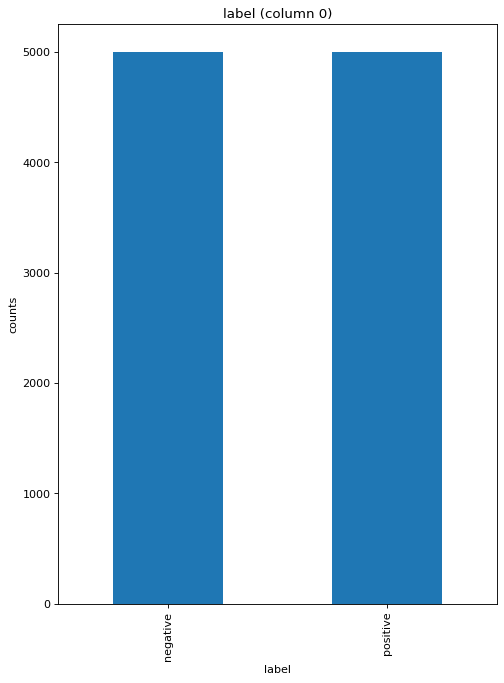

In [17]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

plotPerColumnDistribution(df, 10, 2)

# Split Dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

# Menampilkan hasil
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8000,)
X_test shape: (2000,)
y_train shape: (8000,)
y_test shape: (2000,)


In [9]:
pos_count = 0
neg_count = 0
for y in y_train:
    if y == 'positive':
        pos_count += 1
    if y == 'negative':
        neg_count += 1
        
print('positive count:', pos_count)
print('negative count:', neg_count)

positive count: 4012
negative count: 3988


In [18]:
pos_count = 0
neg_count = 0
for y in y_test:
    if y == 'positive':
        pos_count += 1
    if y == 'negative':
        neg_count += 1
        
print('positive count:', pos_count)
print('negative count:', neg_count)

positive count: 988
negative count: 1012


# TF-IDF

In [20]:
# Inisialisasi objek stopword remover
stopword_factory = StopWordRemoverFactory()
stopwords = stopword_factory.get_stop_words()

#tfidf model
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords)

# menghitung nilai tf-idf
train_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
test_tfidf_matrix = tfidf_vectorizer.transform(X_test)

# Menampilkan hasil
print(train_tfidf_matrix.shape)
print(test_tfidf_matrix.shape)

(8000, 44326)
(2000, 44326)


# Export TF-IDF Model

In [26]:
with open('tfidf_model.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# SMOTE

In [21]:
# Train
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(train_tfidf_matrix, y_train)
X_test_resampled, y_test_resampled = SMOTE(random_state=42).fit_resample(test_tfidf_matrix, y_test)

# Menampilkan hasil
print("X_train_resampled shape:", X_train_resampled.shape)
print("X_test_resampled shape:", X_test_resampled.shape)
print("y_train y_train_resampled:", y_train_resampled.shape)
print("y_test_resampled shape:", y_test_resampled.shape)

X_train_resampled shape: (8024, 44326)
X_test_resampled shape: (2024, 44326)
y_train y_train_resampled: (8024,)
y_test_resampled shape: (2024,)


# SVM

In [22]:
clf = SVC(kernel='rbf')
clf.fit(X_train_resampled, y_train_resampled)

y_pred = clf.predict(X_test_resampled)

print('Accuracy score : ', accuracy_score(y_test_resampled, y_pred))
print('Precision score : ', precision_score(y_test_resampled, y_pred, average='weighted'))
print('Recall score : ', recall_score(y_test_resampled, y_pred, average='weighted'))
print('F1 score : ', f1_score(y_test_resampled, y_pred, average='weighted'))

Accuracy score :  0.9337944664031621
Precision score :  0.9338215764393407
Recall score :  0.9337944664031621
F1 score :  0.9337934320709911


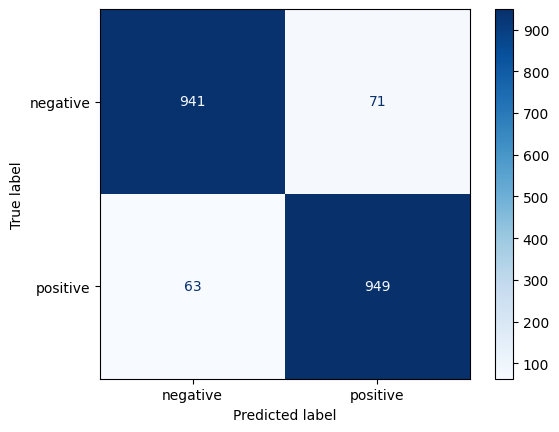

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test_resampled, y_pred, cmap='Blues')
plt.show()

In [24]:
print(classification_report(y_test_resampled, y_pred))

              precision    recall  f1-score   support

    negative       0.94      0.93      0.93      1012
    positive       0.93      0.94      0.93      1012

    accuracy                           0.93      2024
   macro avg       0.93      0.93      0.93      2024
weighted avg       0.93      0.93      0.93      2024



# Export SVM Model

In [25]:
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(clf, f)